# Visualize the MS-SMC' likelihood surface

In [24]:
from pathlib import Path
import toytree
import ipcoal
import pandas as pd
import numpy as np
from scipy import stats

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 4]

In [26]:
print(toytree.__version__)
print(ipcoal.__version__)

3.0.dev8
0.4.dev2


In [27]:
# ! rm -r ../manuscript/figures/likelihood-heatmaps/
DIR = Path("../manuscript/figures/likelihood-heatmaps")
DIR.mkdir(exist_ok=True)

## Parameters

In [28]:
RECOMB = 2e-9
SEED = 123
NEFFS = {0: 4e5, 1: 2e5, 2: 3e5}
ROOT_HEIGHT = 1e6
NSPECIES = 2
NSAMPLES = 6
NSITES = 5e5
NLOCI = 1

NSITES = 1e5
NLOCI = 1

In [29]:
NEFF_MIN = 5e4
NEFF_MAX = 8e5
R_MIN = 1e-9
R_MAX = 3e-9

## Simulate ARGs on a 2-population model

In [30]:
sptree = toytree.rtree.imbtree(NSPECIES, treeheight=ROOT_HEIGHT)
sptree.set_node_data("Ne", NEFFS, inplace=True)
sptree.draw('p');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="300.0px" height="300.0px" viewBox="0 0 300.0 300.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td4b03960df284fff9ea43c3c2399e5dd"> 0 1 2 r0 r1 0 500000 1000000

In [31]:
# get a parameterized ipcoal Model
model = ipcoal.Model(
    sptree,
    nsamples=NSAMPLES,
    recomb=RECOMB,
    seed_trees=SEED,
    discrete_genome=False,
    record_full_arg=True,
)

In [32]:
# get mapping of samples to species
imap = model.get_imap_dict()

### Get trees and interval lengths from tree sequences

In [33]:
# data to fill
trees_r = []
trees_g = []
trees_t = []
dists_r = []
dists_g = []
dists_t = []
events = []

# iterate over each tree sequence
for lidx in range(NLOCI):
    
    # get full tree sequence
    ts = next(model._get_tree_sequence_generator(nsites=NSITES))
    
    # get a simplified version of tree sequence
    sts = ts.simplify(filter_sites=False)
    
    # ...
    sum_tree_dist = 0
    sum_topo_dist = 0
    simple = sts.first(sample_lists=True)
    tree = ts.first(sample_lists=True)
    trees_r.append(simple.copy())
    trees_g.append(simple.copy())
    trees_t.append(simple.copy())
    
    # advanes to next tree in the full tree sequence
    while tree.next():
        
        # get simple tree at this position
        simple = sts.at(tree.interval.left, sample_lists=True)
        
        # store the simplified tree at each full ts breakpoint
        trees_r.append(simple.copy())
        dists_r.append(tree.get_length())
        
        # store the simplified tree and tree-dist IF a tree-change occured
        if simple.kc_distance(trees_g[-1], lambda_=1):
            trees_g.append(simple.copy())
            dists_g.append(sum_tree_dist + tree.get_length())
            sum_tree_dist = 0.
       
            # store the simplified tree and topo-dist IF a topo-change occurred
            if simple.kc_distance(trees_t[-1], lambda_=0):
                trees_t.append(simple.copy())
                dists_t.append(sum_topo_dist + tree.get_length())
                sum_topo_dist = 0.
                events.append(2)
            else:
                sum_topo_dist += tree.get_length()
                events.append(1)
        else:
            sum_tree_dist += tree.get_length()
            sum_topo_dist += tree.get_length()
            events.append(0)
            
    # remove last tree or topo that did not reach a final breakpoint
    trees_r = trees_r[:-1]
    if events[-1] == 0:
        trees_g = trees_g[:-1]
        trees_t = trees_t[:-1]
    elif events[-1] == 1:
        trees_t = trees_t[:-1]

# convert interval lengths to arrays
dists_r = np.array(dists_r)
dists_g = np.array(dists_g)
dists_t = np.array(dists_t)
events = np.array(events)

# ...
trees_r = [toytree.tree(i.as_newick(node_labels=model.tipdict)) for i in trees_r]
trees_g = [toytree.tree(i.as_newick(node_labels=model.tipdict)) for i in trees_g]
trees_t = [toytree.tree(i.as_newick(node_labels=model.tipdict)) for i in trees_t]

### Summarize simulated ARG and recomb event types

In [34]:
print(f"{len(trees_r)} R (recomb) intervals w/ average length={dists_r.mean():.2f}")
print(f"{len(trees_g)} G (tree-change) intervals w/ average length={dists_g.mean():.2f}")
print(f"{len(trees_t)} T (topo-change) intervals w/ average length={dists_t.mean():.2f}")

1411 R (recomb) intervals w/ average length=70.84
1034 G (tree-change) intervals w/ average length=96.76
519 T (topo-change) intervals w/ average length=192.96


In [35]:
dists_r.size, dists_g.size, dists_t.size

(1411, 1033, 518)

In [36]:
(events == 1).sum() + (events == 2).sum()

1033

In [37]:
events[:10]

array([0, 0, 2, 1, 1, 2, 1, 1, 1, 2])

In [38]:
toytree.mtree(trees_r[:8]).draw(shape=(1, 6), fixed_order=trees_r[0].get_tip_labels(), width=900);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="900.0px" height="250.0px" viewBox="0 0 900.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t90cb12dd30e74602b49116b5f52dc52e"> r0_3 r0_1 r0_4 r0_5 r0_0 r0_2 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_3 r0_1 r0_4 r0_5 r0_0 r0_2 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_3 r0_1 r0_4 r0_5 r0_0 r0_2 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_3 r0_0 r0_1 r0_4 r0_5 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_2 r0_3 r0_0 r0_1 r0_4 r0_5 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_2 r0_3 r0_0 r0_1 r0_4 r0_5 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_2

In [39]:
toytree.mtree(trees_g[:8]).draw(shape=(1, 6), fixed_order=trees_g[0].get_tip_labels(), width=900);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="900.0px" height="250.0px" viewBox="0 0 900.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t7a871fd3411c4ec39b66e009d0a5a013"> r0_3 r0_1 r0_4 r0_5 r0_0 r0_2 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_3 r0_0 r0_1 r0_4 r0_5 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_2 r0_3 r0_0 r0_1 r0_4 r0_5 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_2 r0_3 r0_0 r0_1 r0_4 r0_5 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_2 r0_3 r0_1 r0_4 r0_5 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_0 r0_2 r0_3 r0_1 r0_4 r0_5 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_0 r0_2

In [40]:
toytree.mtree(trees_t[:8]).draw(shape=(1, 6), fixed_order=trees_t[0].get_tip_labels(), width=900);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="900.0px" height="250.0px" viewBox="0 0 900.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t13a85fedd7ed4eb4ac166677a6ea0274"> r0_3 r0_1 r0_4 r0_5 r0_0 r0_2 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_3 r0_0 r0_1 r0_4 r0_5 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_2 r0_3 r0_1 r0_4 r0_5 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_0 r0_2 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_3 r0_1 r0_4 r0_5 r0_0 r0_2 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_1 r0_4 r0_5 r0_0 r0_3 r0_2 r1_4 r1_1 r1_3 r1_0 r1_2 r1_5 r0_0 r0_3 r0_2 r0_1 r0_4 r0_5

### Get embedding tables

In [41]:
from ipcoal.msc import _get_msc_loglik_from_embedding
from ipcoal.smc.src.embedding import TreeEmbedding
from ipcoal.smc.src.ms_smc_tree_prob import get_fast_tree_changed_lambdas
from ipcoal.smc.src.ms_smc_topo_prob import get_fast_topo_changed_lambdas
from ipcoal.smc.src.likelihood import get_waiting_distance_loglik, _update_neffs

In [42]:
R = TreeEmbedding(model.tree, trees_r, imap)

In [43]:
G = TreeEmbedding(model.tree, trees_g, imap)

In [44]:
T = TreeEmbedding(model.tree, trees_t, imap)

### Test likelihood methods

In [45]:
# get exponential lambda rate parameters of tree change events @ each tree
_ = get_fast_tree_changed_lambdas(R.emb, R.enc, R.barr, R.sarr, R.rarr, RECOMB)
print(_[:10])

[0.01247899 0.01247899 0.01247899 0.01183487 0.01045674 0.01086536
 0.01133636 0.01150945 0.01171234 0.01200679]


In [46]:
# get exponential lambda rate parameters of tree change events @ each tree
_ = get_fast_tree_changed_lambdas(G.emb, G.enc, G.barr, G.sarr, G.rarr, RECOMB)
print(_[:10])

[0.01247899 0.01183487 0.01045674 0.01086536 0.01133636 0.01150945
 0.01171234 0.01200679 0.00962651 0.00988985]


In [47]:
# get exponential lambda rate parameters of topo change events @ each tree
_ = get_fast_topo_changed_lambdas(T.emb, T.enc, T.barr, T.sarr, T.rarr, RECOMB)
print(_[:10])

[0.00560242 0.00558083 0.00552462 0.00501497 0.00432335 0.00433785
 0.00612343 0.00457989 0.00619925 0.00353959]


#### SMC

In [48]:
get_waiting_distance_loglik(R, RECOMB, dists_r, event_type=0)

7400.343756627792

In [49]:
get_waiting_distance_loglik(G, RECOMB, dists_g, event_type=1)

ValueError: operands could not be broadcast together with shapes (1033,) (1034,) 

In [ ]:
get_waiting_distance_loglik(T, RECOMB, dists_t, event_type=2)

#### MSC

In [ ]:
_get_msc_loglik_from_embedding(R.emb)

In [ ]:
_get_msc_loglik_from_embedding(G.emb)

In [ ]:
_get_msc_loglik_from_embedding(T.emb)

### GRID
These are the ranges of parameters over which we will examine the likelihood surface.

In [50]:
def get_smc_likelihood_surface_Nx_r(
    embedding: TreeEmbedding,
    lengths: np.ndarray,
    event_type: int,
    nidx: int = 0,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int=21,
):
    """Return an array of log likelihood scores over a grid of parameters.
    
    """
    neffs = np.linspace(min_neff, max_neff, n_values)
    recos = np.linspace(min_recomb, max_recomb, n_values)
    X, Y = np.meshgrid(neffs, recos, indexing="ij")
    Z = np.zeros(X.shape)

    for i, n0 in enumerate(neffs):
        
        # update the 2 * diploid Ne values in the Embedding table and get loglik
        params = np.array([NEFFS[i] for i in sorted(NEFFS)])
        params[nidx] = n0
        _update_neffs(embedding.emb, params)
        for j, rec in enumerate(recos):
            Z[i, j] = get_waiting_distance_loglik(embedding, rec, lengths, event_type=event_type)
    return X, Y, Z

In [51]:
def get_msc_likelihood_surface_Nx_r(
    embedding: ipcoal.smc.likelihood.Embedding,
    nidx: int = 0,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int=21,
    #n_recomb_values: int=11,
):
    """Return an array of log likelihood scores for a grid of parameters.
    
    """
    neffs = np.linspace(min_neff, max_neff, n_values)
    recos = np.linspace(min_recomb, max_recomb, n_values)
    X, Y = np.meshgrid(neffs, recos, indexing="ij")
    Z = np.zeros(X.shape)

    for i, n0 in enumerate(neffs):
        
        # update the embedding table with 2Ne
        params = np.array([NEFFS[i] for i in sorted(NEFFS)])
        params[nidx] = n0
        _update_neffs(embedding.emb, params)

        # get expon rate parameter for each embedded genealogy
        Z[i, :] = _get_msc_loglik_from_embedding(embedding.emb)
            
    return X, Y, Z

In [52]:
def get_smc_likelihood_surface_Nx_Ny(
    embedding: ipcoal.smc.likelihood.Embedding,
    lengths: np.ndarray,
    event_type: int,
    nidx: int = 0,
    nidy: int = 1,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    n_values: int=21,
    #n_recomb_values: int=11,
):
    """Return an array of log likelihood scores for a grid of parameters.
    
    """
    neffs0 = np.linspace(min_neff, max_neff, n_values)
    neffs1 = np.linspace(min_neff, max_neff, n_values)
    X, Y = np.meshgrid(neffs0, neffs1, indexing="ij")
    Z = np.zeros(X.shape)
       
    for i, n0 in enumerate(neffs0):
        for j, n1 in enumerate(neffs1):
            
            # update the embedding table with 2Ne
            params = np.array([NEFFS[i] for i in sorted(NEFFS)])
            params[nidx] = n0
            params[nidy] = n1
            _update_neffs(embedding.emb, params)

            # get expon rate parameter for each embedded genealogy
            Z[i, j] = get_waiting_distance_loglik(embedding, RECOMB, lengths, event_type=event_type)
    return X, Y, Z

In [53]:
def get_msc_likelihood_surface_Nx_Ny(
    embedding: ipcoal.smc.likelihood.Embedding,
    nidx: int = 0,
    nidy: int = 1,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int=21,
    #n_recomb_values: int=11,
):
    """Return an array of log likelihood scores for a grid of parameters.
    """
    neffs0 = np.linspace(min_neff, max_neff, n_values)
    neffs1 = np.linspace(min_neff, max_neff, n_values)
    X, Y = np.meshgrid(neffs0, neffs1, indexing="ij")
    Z = np.zeros(X.shape)
       
    for i, n0 in enumerate(neffs0):
        for j, n1 in enumerate(neffs1):
            
            # update the embedding table with 2Ne
            params = np.array([NEFFS[i] for i in sorted(NEFFS)])
            params[nidx] = n0
            params[nidy] = n1
            _update_neffs(embedding.emb, params)

            # get expon rate parameter for each embedded genealogy
            Z[i, j] = _get_msc_loglik_from_embedding(embedding.emb)

    return X, Y, Z

In [ ]:
plt.contourf()

In [145]:
def plot_likelihood_surface_Nx_Ny(x, y, z, nidx=0, nidy=1, levels=30, title="", vmin=None):
    fig, ax = plt.subplots()
    vmin = -z.max() + (z.max() - z.min()) / 10
    cs = ax.contourf(x, y, -z, levels=40, cmap='viridis', vmin=vmin, linestyles='solid')
    _ = ax.contour(x, y, -z, 40, colors='k', linestyles='solid', linewidths=0.75)  # Negative contours default to dashed.
    ma = ax.scatter(NEFFS[nidx], NEFFS[nidy], marker="x", s=70)
    cbar = fig.colorbar(cs, label="log likelihood")
    ax.set_xlabel(f'Diploid N$_e${nidx}', fontsize=16)
    ax.set_ylabel(f'Diploid N$_e${nidy}', fontsize=16);
    ax.set_xticks([200_000, 400_000, 600_000, 800_000])
    ax.set_yticks([200_000, 400_000, 600_000, 800_000])
    ax.tick_params(axis='both', which='major', labelsize=12) # pad?
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_title(title, fontsize=16, pad=15)
    return fig, ax, (cs, ma, cbar)

In [146]:
def plot_likelihood_surface_r_Nx(x, y, z, nidx=0, levels=30, title="", vmin=None):
    fig, ax = plt.subplots()
    vmin = -z.max() + (z.max() - z.min()) / 10
    cs = ax.contourf(x, y, -z, levels=levels, cmap='viridis', vmin=vmin, linestyles='solid')
    ma = ax.scatter(NEFFS[nidx], RECOMB, marker="x", s=70)
    cbar = fig.colorbar(cs, label="log likelihood")
    ax.set_xlabel(f'Diploid N$_e${nidx}', fontsize=16);
    ax.set_ylabel('Recombination rate (r)', fontsize=16)
    ax.set_xticks([200_000, 400_000, 600_000, 800_000])
    ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_title(title, fontsize=16, pad=15)
    return fig, ax, (cs, ma, cbar)

### PLOT GRIDS

In [147]:
MSC = {}
SMC = {}

#### MSC fit (Ne0, Ne1) using tree-change or topo-change trees

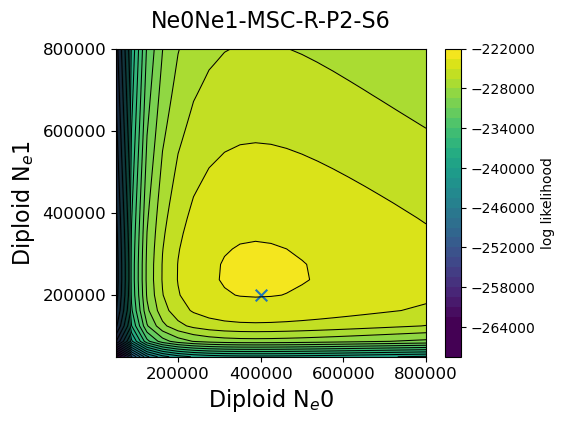

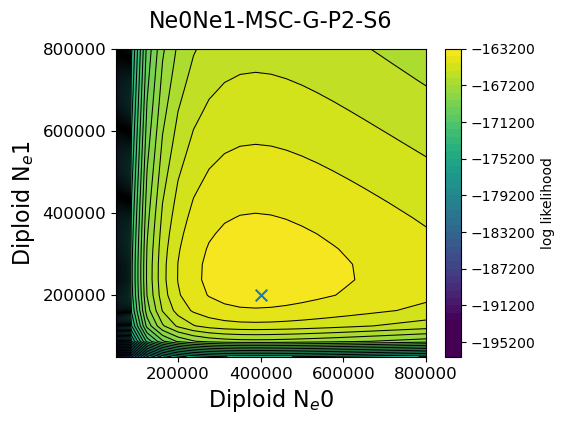

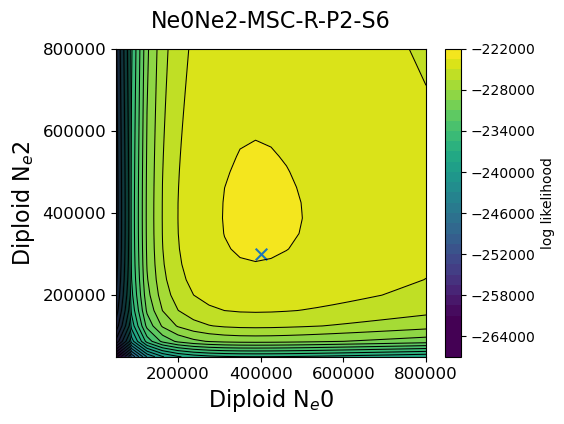

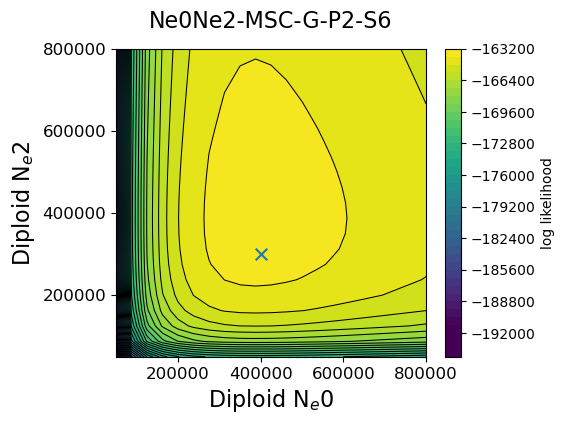

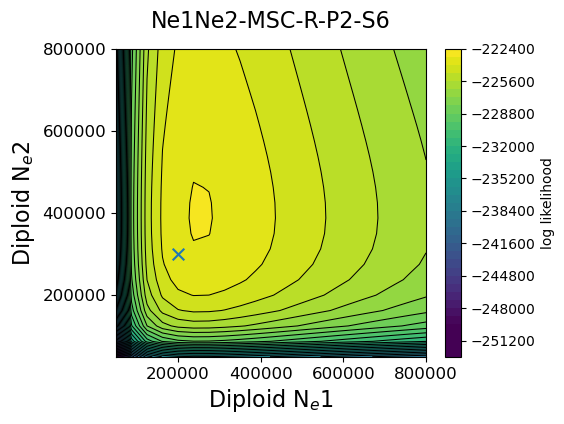

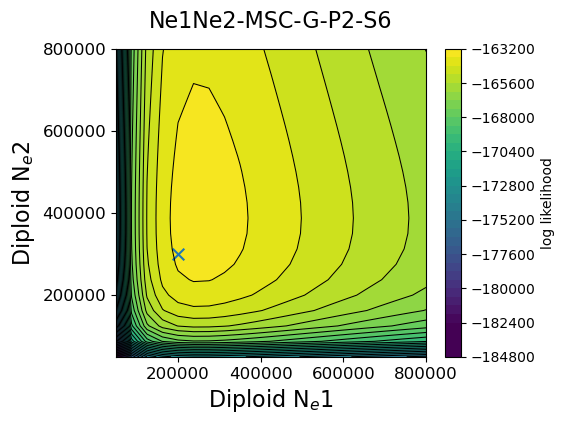

In [148]:
for nx, ny in [(0, 1), (0, 2), (1, 2)]:

    MSC_N_R = get_msc_likelihood_surface_Nx_Ny(
        R,
        nx, ny,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
    )
    
    MSC_N_G = get_msc_likelihood_surface_Nx_Ny(
        G,
        nx, ny,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
    )

    MSC_N_T = get_msc_likelihood_surface_Nx_Ny(
        T,
        nx, ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
    )
    
    # store for later
    MSC[(nx, ny, 'r')] = MSC_N_R
    MSC[(nx, ny, 'g')] = MSC_N_G
    MSC[(nx, ny, 't')] = MSC_N_T
    MSC[(nx, ny, 'gt')] = MSC_N_G[0], MSC_N_G[1], MSC_N_G[2] + MSC_N_T[2]

    # plot it
    title = f"Ne{nx}Ne{ny}-MSC-R-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC_N_R, nidx=nx, nidy=ny, title=title);
#     c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-MSC-G-P{NSPECIES}-S{NSAMPLES}"
    c, a, m = plot_likelihood_surface_Nx_Ny(*MSC_N_G, nidx=nx, nidy=ny, title=title);
#     c.savefig((DIR / title).with_suffix('.svg'))

#     title = f"Ne{nx}Ne{ny}-MSC-T-P{NSPECIES}-S{NSAMPLES}"
#     c, a, m = plot_likelihood_surface_Nx_Ny(*MSC_N_T, nidx=nx, nidy=ny, title=title);
#     c.savefig((DIR / title).with_suffix('.svg'))
    
#     title = f"Ne{nx}Ne{ny}-MSC-GT-P{NSPECIES}-S{NSAMPLES}"
#     c, a, m = plot_likelihood_surface_Nx_Ny(*MSC[(nx, ny, 'gt')], nidx=nx, nidy=ny, title=title);
#     c.savefig((DIR / title).with_suffix('.svg'))

#### MSC fit (r, Ne0) using tree-change or topo-change trees

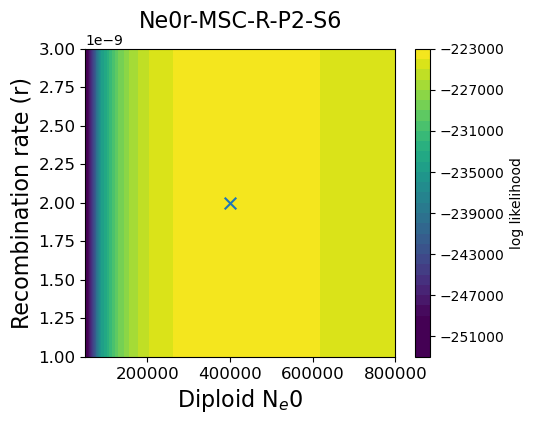

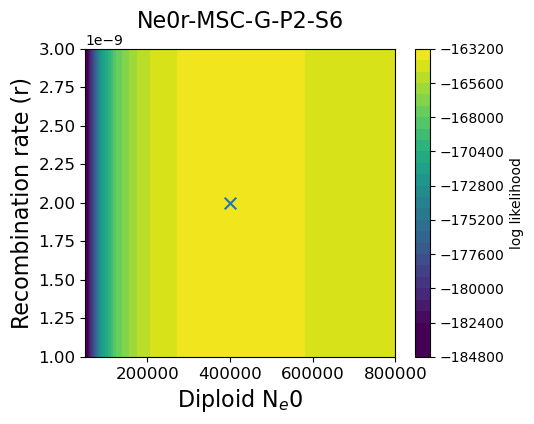

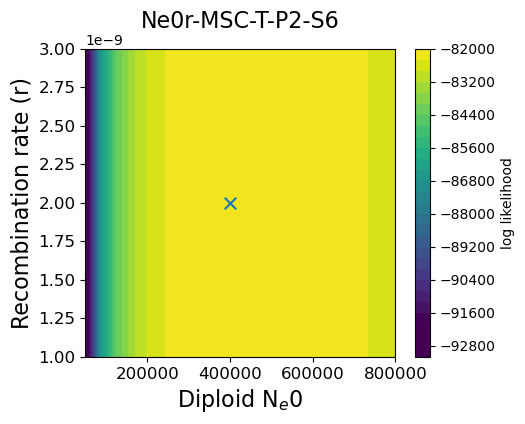

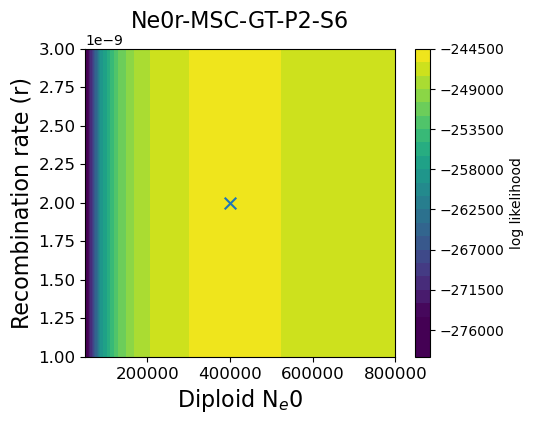

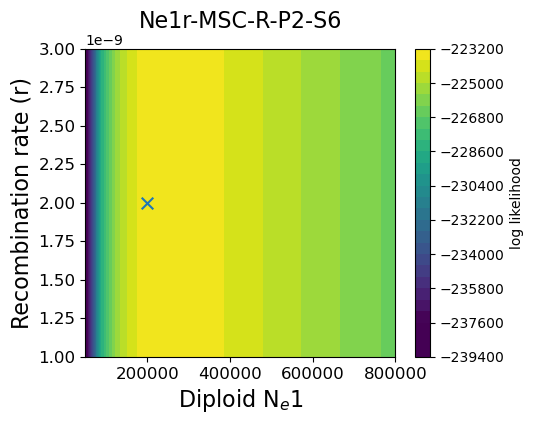

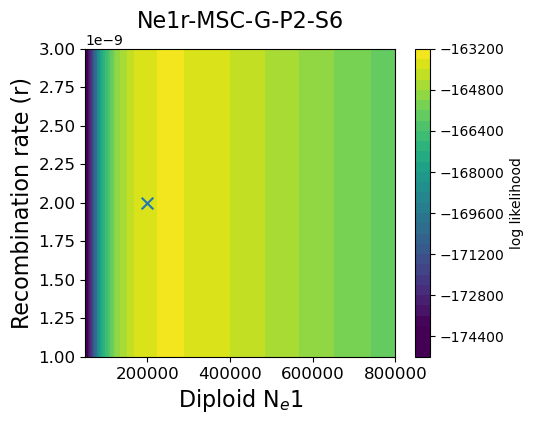

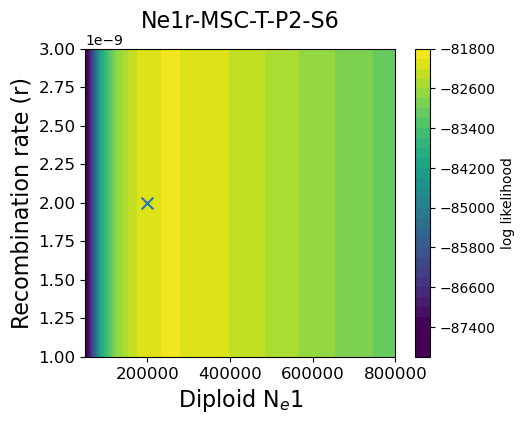

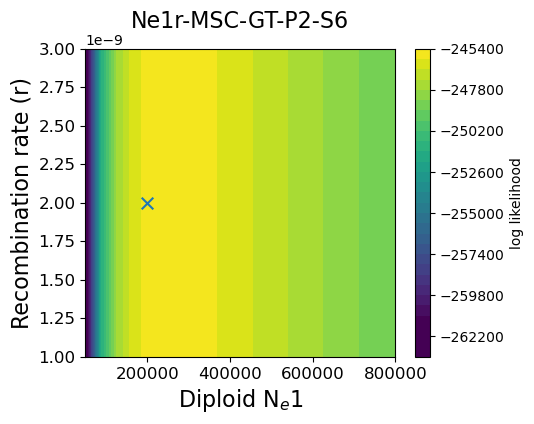

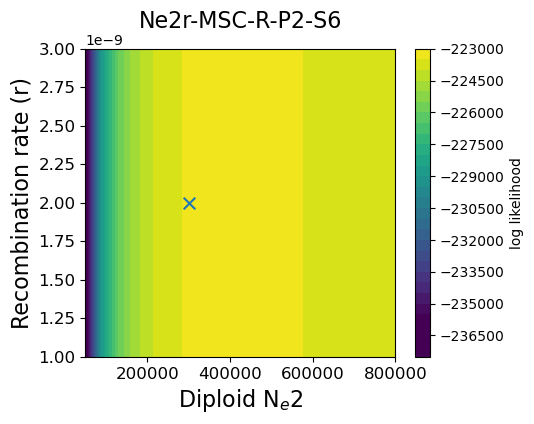

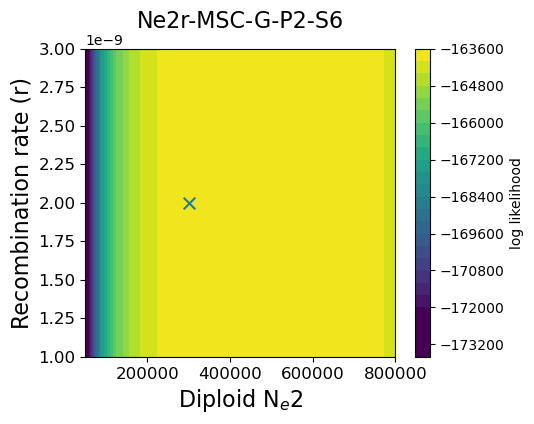

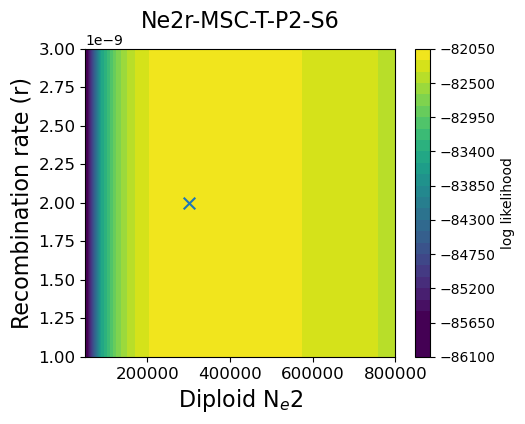

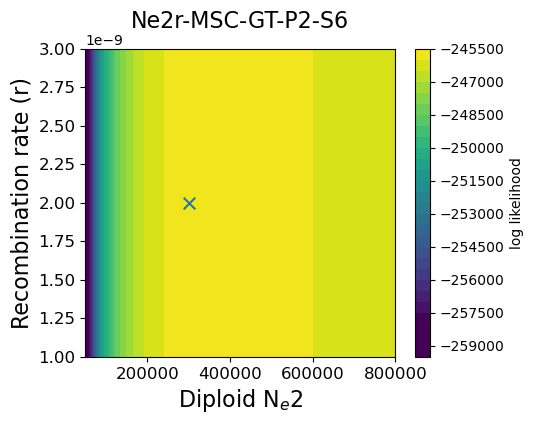

In [144]:
for nx in range(sptree.nnodes):

    MSC_r_R = get_msc_likelihood_surface_Nx_r(
        R,
        nidx=nx,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
    )
    
    MSC_r_G = get_msc_likelihood_surface_Nx_r(
        G,
        nidx=nx,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
    )

    MSC_r_T = get_msc_likelihood_surface_Nx_r(
        T,
        nidx=nx,
        min_neff=NEFF_MIN,
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
    )
    
    # store for later
    MSC[(nx, 'r', 'r')] = MSC_r_R
    MSC[(nx, 'r', 'g')] = MSC_r_G
    MSC[(nx, 'r', 't')] = MSC_r_T
    MSC[(nx, 'r', 'gt')] = MSC_r_G[0], MSC_r_G[1], MSC_r_G[2] + MSC_r_T[2]

    # plot it
    title = f"Ne{nx}r-MSC-R-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC_r_R, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}r-MSC-G-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC_r_G, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}r-MSC-T-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC_r_T, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"Ne{nx}r-MSC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*MSC[(nx, 'r', 'gt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

#### SMC fit (Ne0, Ne1) using tree-change or topo-change trees and lengths

In [ ]:
for nx, ny in [(0, 1), (0, 2), (1, 2)]:

    SMC_N_R = get_smc_likelihood_surface_Nx_Ny(
        R,
        dists_r,
        event_type=0,
        nidx=nx, nidy=ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
    )
    
    SMC_N_G = get_smc_likelihood_surface_Nx_Ny(
        G,
        dists_g,
        event_type=1,
        nidx=nx, nidy=ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
    )

    SMC_N_T = get_smc_likelihood_surface_Nx_Ny(
        T,
        dists_t,
        event_type=2,
        nidx=nx, nidy=ny,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
    )
    
    # store for later
    SMC[(nx, ny, 'r')] = SMC_N_R  
    SMC[(nx, ny, 'g')] = SMC_N_G
    SMC[(nx, ny, 't')] = SMC_N_T
    SMC[(nx, ny, 'gt')] = SMC_N_G[0], SMC_N_G[1], SMC_N_G[2] + SMC_N_T[2]
    
    # plot it    
    title = f"Ne{nx}Ne{ny}-SMC-R-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC_N_R, nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))
    
    title = f"Ne{nx}Ne{ny}-SMC-G-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC_N_G, nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-SMC-T-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC_N_T, nidx=nx, nidy=ny, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne{nx}Ne{ny}-SMC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_Nx_Ny(*SMC[(nx, ny, 'gt')], nidx=nx, nidy=ny, title=title)
    c.savefig((DIR / title).with_suffix('.svg'))

#### SMC fit (r, Ne0) using tree-change or topo-change trees and lengths

In [ ]:
for nx in range(sptree.nnodes):

    SMC_r_R = get_smc_likelihood_surface_Nx_r(
        R,
        dists_r,
        event_type=0,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
    )
    
    SMC_r_G = get_smc_likelihood_surface_Nx_r(
        G,
        dists_g,
        event_type=1,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
    )

    SMC_r_T = get_smc_likelihood_surface_Nx_r(
        T,
        dists_t,
        event_type=2,
        nidx=nx,
        min_neff=NEFF_MIN, 
        max_neff=NEFF_MAX,
        min_recomb=R_MIN,
        max_recomb=R_MAX,
    )
    
    # store for later
    SMC[(nx, 'r', 'r')] = SMC_r_R
    SMC[(nx, 'r', 'g')] = SMC_r_G
    SMC[(nx, 'r', 't')] = SMC_r_T
    SMC[(nx, 'r', 'gt')] = SMC_r_G[0], SMC_r_G[1], SMC_r_G[2] + SMC_r_T[2]

    title = f"Ne0r-SMC-R-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_r_R, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne0r-SMC-G-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_r_G, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne0r-SMC-T-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC_r_T, nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

    title = f"Ne0r-SMC-GT-P{NSPECIES}-S{NSAMPLES}"
    c, _, _ = plot_likelihood_surface_r_Nx(*SMC[(nx, 'r', 'gt')], nidx=nx, title=title);
    c.savefig((DIR / title).with_suffix('.svg'))

#### COMBINED

In [ ]:
for nx, ny in [(0, 1), (0, 2), (1, 2)]:
    
    for e in ('r', 'g', 't', 'gt'):
        
        msc = MSC[(nx, ny, e)]
        smc = SMC[(nx, ny, e)]
        title = f"Ne{nx}Ne{ny}-MSSMC-{e.upper()}-P{NSPECIES}-S{NSAMPLES}"
        c, _, _ = plot_likelihood_surface_Nx_Ny(msc[0], msc[1], msc[2] + smc[2], nidx=nx, nidy=ny, title=title)
        c.savefig((DIR / title).with_suffix('.svg'))

In [ ]:
for nx in range(sptree.nnodes):
    
    for e in ('r', 'g', 't', 'gt'):
        
        msc = MSC[(nx, 'r', e)]
        smc = SMC[(nx, 'r', e)]

        title = f"Ne{nx}r-MSSMC-{e.upper()}-P{NSPECIES}-S{NSAMPLES}"
        c, _, _ = plot_likelihood_surface_r_Nx(msc[0], msc[1], msc[2] + smc[2], nidx=nx, title=title);
        c.savefig((DIR / title).with_suffix('.svg'))

In [50]:
list(MSC)

[(0, 1, 'r'),
 (0, 1, 'g'),
 (0, 1, 't'),
 (0, 1, 'gt'),
 (0, 2, 'r'),
 (0, 2, 'g'),
 (0, 2, 't'),
 (0, 2, 'gt'),
 (1, 2, 'r'),
 (1, 2, 'g'),
 (1, 2, 't'),
 (1, 2, 'gt'),
 (0, 'r', 'r'),
 (0, 'r', 'g'),
 (0, 'r', 't'),
 (0, 'r', 'gt'),
 (1, 'r', 'r'),
 (1, 'r', 'g'),
 (1, 'r', 't'),
 (1, 'r', 'gt'),
 (2, 'r', 'r'),
 (2, 'r', 'g'),
 (2, 'r', 't'),
 (2, 'r', 'gt')]

In [51]:
list(SMC)

[(0, 'r', 'r'),
 (0, 'r', 'g'),
 (0, 'r', 't'),
 (0, 'r', 'gt'),
 (1, 'r', 'r'),
 (1, 'r', 'g'),
 (1, 'r', 't'),
 (1, 'r', 'gt'),
 (2, 'r', 'r'),
 (2, 'r', 'g'),
 (2, 'r', 't'),
 (2, 'r', 'gt'),
 (0, 1, 'r'),
 (0, 1, 'g'),
 (0, 1, 't'),
 (0, 1, 'gt'),
 (0, 2, 'r'),
 (0, 2, 'g'),
 (0, 2, 't'),
 (0, 2, 'gt'),
 (1, 2, 'r'),
 (1, 2, 'g'),
 (1, 2, 't'),
 (1, 2, 'gt')]

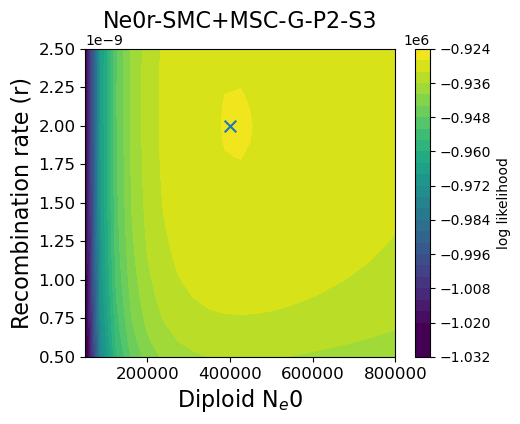

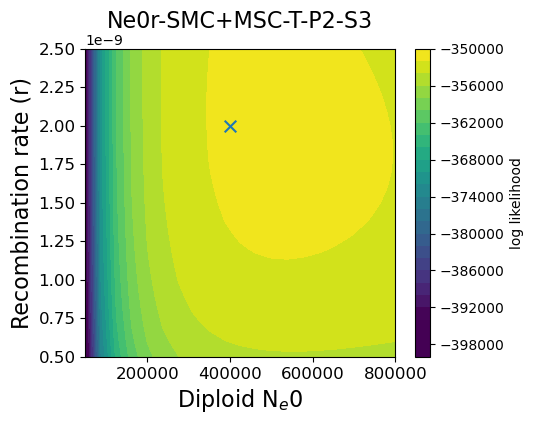

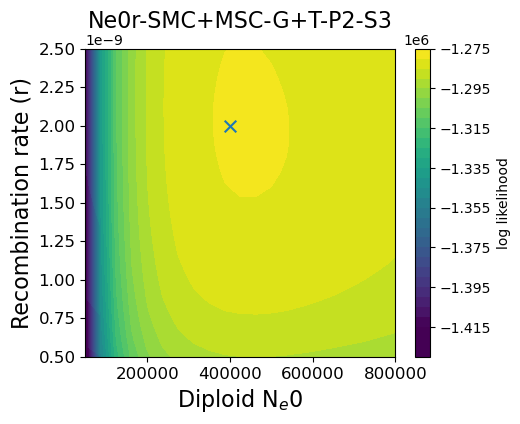

In [94]:
# X = 1
title = f"Ne0r-SMC+MSC-G-P{NSPECIES}-S{NSAMPLES}"
c, _, _ = plot_likelihood_surface_r_N0(SMC_r_G[0], SMC_r_G[1], SMC_r_G[2] + MSC_r_G[2], title=title);
c.savefig((DIR / title).with_suffix('.svg'))

title = f"Ne0r-SMC+MSC-T-P{NSPECIES}-S{NSAMPLES}"
c, _, _ = plot_likelihood_surface_r_N0(SMC_r_T[0], SMC_r_T[1], SMC_r_T[2] + MSC_r_T[2], title=title);
c.savefig((DIR / title).with_suffix('.svg'))

title = f"Ne0r-SMC+MSC-G+T-P{NSPECIES}-S{NSAMPLES}"
c, _, _ = plot_likelihood_surface_r_N0(SMC_r_T[0], SMC_r_T[1], SMC_r_T[2] + MSC_r_T[2] + SMC_r_G[2] + MSC_r_G[2], title=title);
c.savefig((DIR / title).with_suffix('.svg'))

In [204]:
Xg, Yg, Zg = get_smc_likelihood_surface(
    G,
    tree_lengths,
    get_waiting_distance_loglik,
    min_neff=50_000,
    max_neff=800_000,
    min_recomb=1e-9, 
    max_recomb=3e-9,
)

In [205]:
Xt, Yt, Zt = get_smc_likelihood_surface(
    T,
    topo_lengths,
    get_waiting_distance_loglik,
    topology=True,
    min_neff=50_000,
    max_neff=800_000,
    min_recomb=1e-9, 
    max_recomb=3e-9,
)

In [208]:
X, Y, Z = get_smc_likelihood_surface_N(
    T,
    topo_lengths,
    get_waiting_distance_loglik,
    topology=True,
    min_neff=20_000, 
    max_neff=400_000,
)

In [209]:
def plot_likelihood_surface2(x, y, z, levels=20, title="", vmin=None):
    fig, ax = plt.subplots()
    cs = ax.contourf(x, y, -z, levels=levels, cmap='viridis', vmin=vmin, linestyles='solid')
    ma = ax.scatter(NEFF, RECOMB, marker="x", s=50)
    cbar = fig.colorbar(cs, label="log likelihood")
    ax.set_ylabel('Recombination rate (r)', fontsize=16)
    ax.set_xlabel('Diploid N$_e$', fontsize=16);
    #ax.set_xticks([200_000, 400_000, 600_000, 800_000])
    ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_title(title, fontsize=16, pad=15)
    return fig, ax, (cs, ma, cbar)


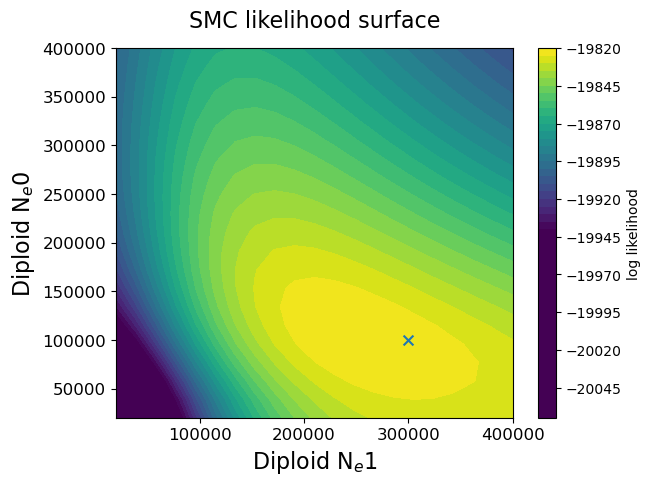

In [210]:
# cx, cy, cz = Xmg, Ymg, Zmg
cx, cy, cz = Xmt, Ymt, Zmt
cx, cy, cz = X, Y, Z
fig, _, _ = plot_likelihood_surfaceN(
    cx, cy, cz.T, 
    levels=50,
    vmin=-cz.max() + (cz.max() - cz.min()) / 2,
    title="SMC likelihood surface",
);
#fig.savefig('../manuscript/figures/new-likelihood-surface-MSC-final.jpg')
#fig.savefig('../manuscript/figures/new-likelihood-surface-MSC-final.svg')

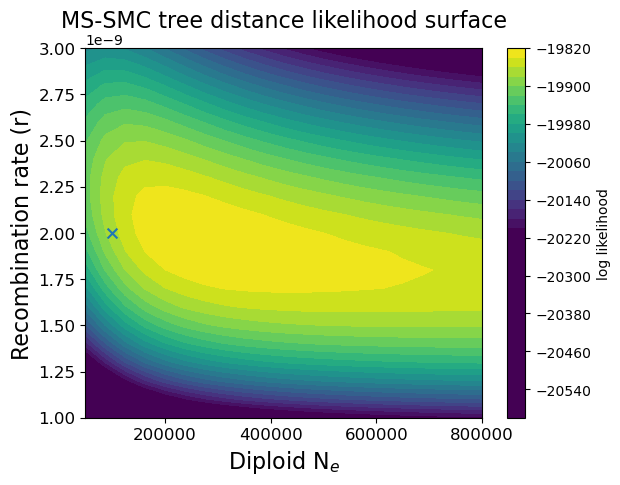

In [213]:
cx, cy, cz = Xg, Yg, Zg
cx, cy, cz = Xt, Yt, Zt
fig, _, _ = plot_likelihood_surface2(
    cx, cy, cz.T, 
    levels=50,
    vmin=-cz.max() + (cz.max() - cz.min()) / 2,
    title="MS-SMC tree distance likelihood surface",
);
#fig.savefig('../manuscript/figures/new-likelihood-surface-SMCtree-final.jpg')
#fig.savefig('../manuscript/figures/new-likelihood-surface-SMCtree-final.svg')

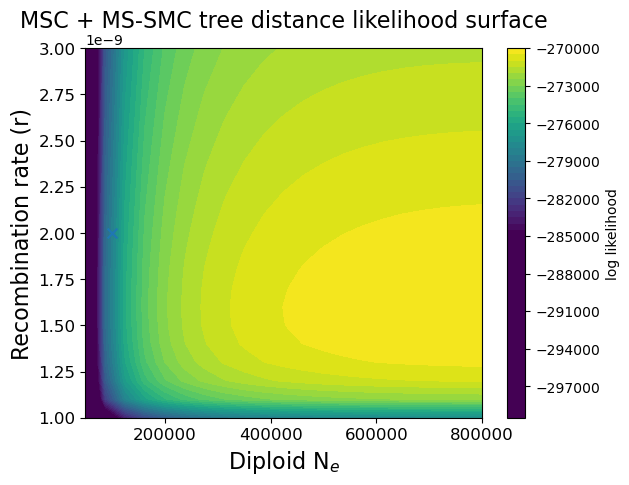

In [217]:
cx, cy, cz = Xg, Yg, 1 * Zg + Zmt
cx, cy, cz = Xt, Yt, Zt + Zmt

#cx, cy, cz = Xg, Yg, (Zg / Zg.max()) / 2 + (Zmg / Zmg.max()) / 2

fig, _, _ = plot_likelihood_surface2(
    cx, cy, cz.T,
    levels=60,
    vmin=-cz.max() + (cz.max() - cz.min()) / 2,
    title="MSC + MS-SMC tree distance likelihood surface",
);
#fig.savefig('../manuscript/figures/new-likelihood-surface-MSC_SMCtree-final.jpg')
#fig.savefig('../manuscript/figures/new-likelihood-surface-MSC_SMCtree-final.svg')

In [144]:
cx, cy, cz = Xg, Yg, 100 * Zg + Zmg
cx, cy, cz = Xg, Yg, (Zg / Zg.max()) / 2 + (Zmg / Zmg.max()) / 2

fig, _, _ = plot_likelihood_surface2(
    cx, cy, cz.T,
    levels=50,
    vmin=-cz.max() + (cz.max() - cz.min()) / 2,
    title="MSC + MS-SMC tree distance likelihood surface",
);
#fig.savefig('../manuscript/figures/new-likelihood-surface-MSC_SMCtree-final.jpg')
#fig.savefig('../manuscript/figures/new-likelihood-surface-MSC_SMCtree-final.svg')

NameError: name 'Zmg' is not defined

In [218]:
cx, cy, cz = Xmg, Ymg, Zmg
#cx, cy, cz = Xg, Yg, Zg
# cx, cy, cz = Xg, Yg, 2 * Zg + Zmg 

fig, _, _ = plot_likelihood_surface2(
    cx, cy, cz.T, 
    levels=60,
    vmin=-cz.max() + (cz.max() - cz.min()) / 2,
    title="MSC likelihood surface",
);
#fig.savefig('../manuscript/figures/likelihood-surface-MSC-final.jpg')
#fig.savefig('../manuscript/figures/likelihood-surface-MSC-final.svg')

NameError: name 'Xmg' is not defined

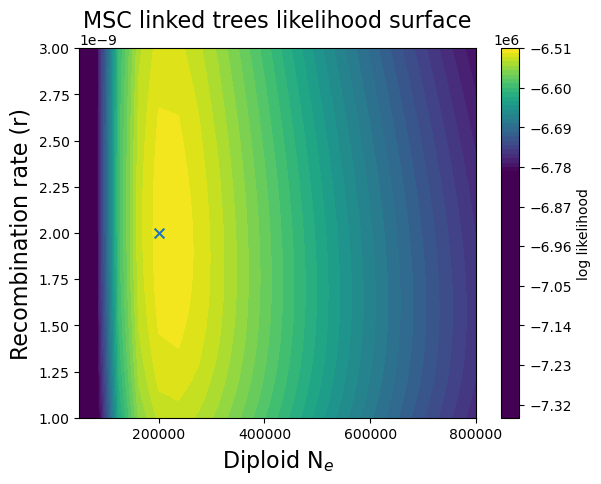

In [103]:
cx, cy, cz = Xmg, Ymg, Zmg
#cx, cy, cz = Xg, Yg, Zg
cx, cy, cz = Xg, Yg, 2 * Zg + Zmg 

fig, _, _ = plot_likelihood_surface2(
    cx, cy, cz.T, 
    levels=100,
    #vmin=-cz.max(),
    vmin=-cz.max() + (cz.max() - cz.min()) / 1.5,
    title="MSC linked trees likelihood surface",
);
#fig.savefig('../manuscript/figures/likelihood-surface-MSC-final.jpg')
#fig.savefig('../manuscript/figures/likelihood-surface-MSC-final.svg')

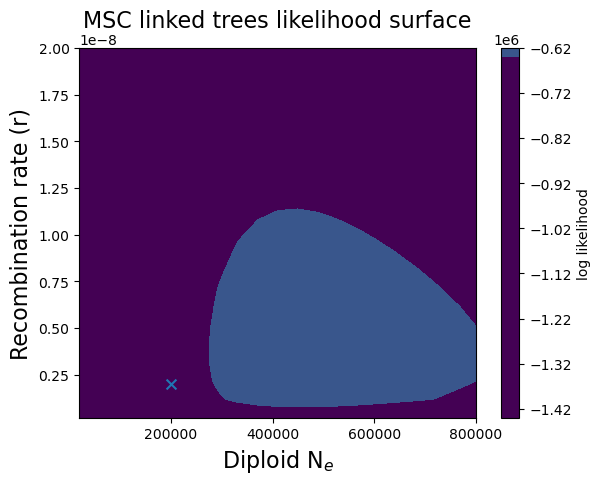

In [47]:
cx, cy, cz = Xmg, Ymg, Zmg
cx, cy, cz = Xg, Yg, Zg
cx, cy, cz = Xg + Xmg, Yg + Ymg, Zg + Zmg

fig, _, _ = plot_likelihood_surface(
    cx, cy, cz.T, 
    levels=50,
    vmin=-cz.max() + (cz.max() - cz.min()),
    title="MSC linked trees likelihood surface",
);
#fig.savefig('../manuscript/figures/likelihood-surface-MSC-final.jpg')
#fig.savefig('../manuscript/figures/likelihood-surface-MSC-final.svg')

In [ ]:
Xmt, Ymt, Zmt = get_msc_likelihood_surface(gdata)

In [41]:
def get_likelihood_surface(
    topology: bool,
    embedding: ipcoal.smc.likelihood.Embedding,
    lengths: np.ndarray,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int=21,
    #n_recomb_values: int=11,
    ):
    """Return an array of log likelihood scores for a grid of parameters.
    
    """
    neffs = np.linspace(min_neff, max_neff, n_values)
    recos = np.linspace(min_recomb, max_recomb, n_values)
    X, Y = np.meshgrid(neffs, recos)
    Z = np.zeros(X.shape)

    for i, neff in enumerate(neffs):
        
        ipcoal.smc.likelihood.ms_smc_jit._update_neffs(embedding.earr, np.array([neff, neff, neff]))
        if topology:
            earr, barr, sarr, rarr = embedding.get_data()
            args = (earr, barr, sarr, rarr, 1)
            rates = ipcoal.smc.likelihood.ms_smc_jit.get_fast_waiting_distance_to_topology_change_rates(*args)
        else:
            earr, barr, sarr = embedding.get_data()
            args = (earr, barr, sarr, 1)
            rates = ipcoal.smc.likelihood.ms_smc_jit.get_fast_waiting_distance_to_tree_change_rates(*args)

        for j, rec in enumerate(recos):
            lambdas = rates * rec         
            Z[i, j] = -np.sum(stats.expon.logpdf(scale=1/lambdas, x=lengths))
            #print(f"{i}\t{j}\t{neff:.0f}\t{rec:1.2g}\t{Z[i,j]:.0f}")
    return X, Y, Z

In [39]:
def get_combined_likelihood_surface(
    tree_embedding: ipcoal.smc.likelihood.TreeEmbedding,
    topo_embedding: ipcoal.smc.likelihood.TreeEmbedding,
    tree_lengths: np.ndarray,
    topo_lengths: np.ndarray,
    min_neff: int = 10_000,
    max_neff: int = 400_000,
    min_recomb: float = 0.1e-9,
    max_recomb: float = 10e-9,
    n_values: int=21,
    #n_recomb_values: int=11,
    ):
    """Return an array of log likelihood scores for a grid of parameters.
    
    """
    neffs = np.linspace(min_neff, max_neff, n_values)
    recos = np.linspace(min_recomb, max_recomb, n_values)
    X, Y = np.meshgrid(neffs, recos)
    Z = np.zeros(X.shape)
       
    for i, neff in enumerate(neffs):
        
        ipcoal.smc.likelihood.ms_smc_jit._update_neffs(tree_embedding.earr, np.array([neff, neff, neff]))
        ipcoal.smc.likelihood.ms_smc_jit._update_neffs(topo_embedding.earr, np.array([neff, neff, neff]))

        earr, barr, sarr, rarr = topo_embedding.get_data()
        topo_rates = ipcoal.smc.likelihood.ms_smc_jit.get_fast_waiting_distance_to_topology_change_rates(earr, barr, sarr, rarr, 1)
        
        earr, barr, sarr = tree_embedding.get_data()
        tree_rates = ipcoal.smc.likelihood.ms_smc_jit.get_fast_waiting_distance_to_tree_change_rates(earr, barr, sarr, 1)

        for j, rec in enumerate(recos):
            topo_lambdas = topo_rates * rec 
            tree_lambdas = tree_rates * rec
            topo_loglik = -np.sum(stats.expon.logpdf(scale=1/topo_lambdas, x=topo_lengths))
            tree_loglik = -np.sum(stats.expon.logpdf(scale=1/tree_lambdas, x=tree_lengths))
            Z[i, j] = topo_loglik + tree_loglik
            #print(f"{i}\t{j}\t{neff:.0f}\t{rec:1.2g}\t{Z[i,j]:.0f}")
    return X, Y, Z

In [42]:
def plot_likelihood_surface(x, y, z, levels=20, title="", vmin=None):
    fig, ax = plt.subplots()
    cs = ax.contourf(x, y, -z, levels=levels, cmap='viridis', vmin=vmin, linestyles='solid')
    ma = ax.scatter(NEFF, RECOMB, marker="x", s=50)
    cbar = fig.colorbar(cs, label="log likelihood")
    ax.set_ylabel('Recombination rate (r)', fontsize=16)
    ax.set_xlabel('Diploid N$_e$', fontsize=16);
    ax.set_xticks([200_000, 400_000, 600_000, 800_000])
    ax.set_title(title, fontsize=16, pad=15)
    return fig, ax, (cs, ma, cbar)

### Calculate MSC likelihood

In [40]:
cx, cy, cz = get_msc_likelihood_surface(
    topology=False,
    embedding=gdata,
    min_neff=50_000,
    max_neff=800_000, 
    n_values=41,
)

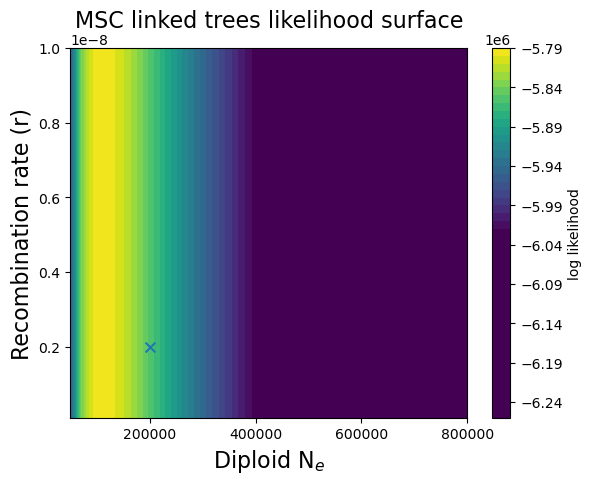

In [48]:
fig, _, _ = plot_likelihood_surface(
    cx, cy, cz.T, 
    levels=50, 
    vmin=-cz.max() + (cz.max() - cz.min()) / 2,
    title="MSC linked trees likelihood surface",
);
fig.savefig('../manuscript/figures/likelihood-surface-MSC-final.jpg')
fig.savefig('../manuscript/figures/likelihood-surface-MSC-final.svg')

## Calculate combined information likelihood

In [ ]:
cx, cy, cz = get_combined_likelihood_surface(
    min_neff=50_000, max_neff=800_000, n_values=41,
    min_recomb=1e-9, max_recomb=3e-9,
    tree_embedding=gdata, 
    tree_lengths=tree_lengths,
    topo_embedding=tdata,
    topo_lengths=topo_lengths,
)

### Plot combined info likelihood surface

In [ ]:
fig, _, _ = plot_likelihood_surface(
    cx, cy, cz.T, 
    levels=50, 
    vmin=-cz.max() + (cz.max() - cz.min()) / 2,
    title="Combined info likelihood surface",
);
#fig.savefig('../manuscript/figures/likelihood-surface-combined-final.jpg')
#fig.savefig('../manuscript/figures/likelihood-surface-combined-final.svg')

### Topology distance likelihood surface

In [72]:
tx, ty, tz = get_likelihood_surface(
    min_neff=50_000, max_neff=800_000, n_values=41,
    min_recomb=1e-9, max_recomb=3e-9,
    topology=True, 
    embedding=tdata, 
    lengths=topo_lengths)

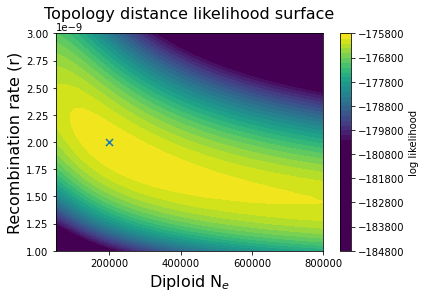

In [77]:
fig, _, _ = plot_likelihood_surface(
    tx, ty, tz.T,
    levels=50, 
    vmin=-tz.max() + (tz.max() - tz.min()) / 2,
    title="Topology distance likelihood surface",
);
#fig.savefig('../manuscript/figures/likelihood-surface-topodist-final.jpg')
#fig.savefig('../manuscript/figures/likelihood-surface-topodist-final.svg')

### Tree distance likelihood surface

In [78]:
gx, gy, gz = get_likelihood_surface(
    min_neff=50_000, max_neff=800_000, n_values=41,
    min_recomb=1e-9, max_recomb=3e-9,
    topology=False, 
    embedding=gdata, 
    lengths=tree_lengths)

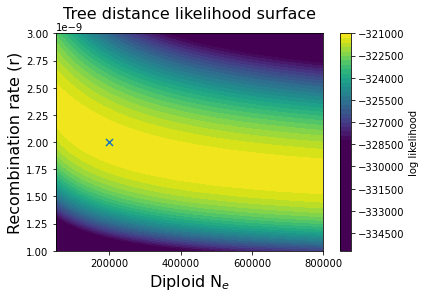

In [82]:
fig, _, _ = plot_likelihood_surface(
    gx, gy, gz.T,
    levels=50, 
    vmin=-gz.max() + (gz.max() - gz.min()) / 2,
    title="Tree distance likelihood surface");
#fig.savefig('../manuscript/figures/likelihood-surface-treedist-final.jpg')
#fig.savefig('../manuscript/figures/likelihood-surface-treedist-final.svg')

# Compare to when the MSC model is incorrect

What if we try to estimate parameters from genealogies generated under a 2-population model but fit to a single population model? This is analogous to when studying an organism with population structure but ignoring the structure. 

In [83]:
# embed genealogies into a single population model
single_pop = toytree.tree("(p);").set_node_data("Ne", default=200_000)
new_imap = {'p': sorted(set.union(*[set(i) for i in imap.values()]))}

In [85]:
bdata_tree = ipcoal.smc.likelihood.TreeEmbedding(single_pop, genealogies, imap=new_imap)

In [86]:
bdata_topo = ipcoal.smc.likelihood.TopologyEmbedding(single_pop, genealogies, imap=new_imap)

In [89]:
bcx, bcy, bcz = get_combined_likelihood_surface(
    min_neff=50_000, max_neff=800_000, n_values=41,
    min_recomb=1e-9, max_recomb=3e-9,
    tree_embedding=bdata_tree, 
    tree_lengths=tree_lengths,
    topo_embedding=bdata_topo,
    topo_lengths=topo_lengths,
)

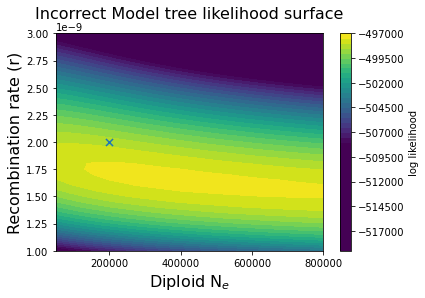

In [91]:
fig, _, _ = plot_likelihood_surface(
    bcx, bcy, bcz.T,
    levels=50,
    vmin=-bcz.max() + (bcz.max() - bcz.min()) / 2,
    title="Incorrect Model tree likelihood surface",
);
#fig.savefig('../manuscript/figures/likelihood-surface-treedist-incorrect-final.jpg')
#fig.savefig('../manuscript/figures/likelihood-surface-treedist-incorrect-final.svg')